In [2]:
#Import neccesary libraries 

import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [3]:
data = "/kaggle/input/environmental-sound-classification-50/audio/audio/44100/"
df = pd.read_csv('/kaggle/input/environmental-sound-classification-50/esc50.csv')
AUDIO_DIR = "/kaggle/input/environmental-sound-classification-50/audio/audio/44100/"

print(df.head())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [4]:
# Count samples per class
class_counts = df['category'].value_counts().sort_index()

# Print total number of unique classes
print(f" Total unique classes: {df['category'].nunique()}\n")

# Print sample count per class
print("Samples per class:\n")
for cls, count in class_counts.items():
    print(f"{cls:25s} → {count} samples")

 Total unique classes: 50

Samples per class:

airplane                  → 40 samples
breathing                 → 40 samples
brushing_teeth            → 40 samples
can_opening               → 40 samples
car_horn                  → 40 samples
cat                       → 40 samples
chainsaw                  → 40 samples
chirping_birds            → 40 samples
church_bells              → 40 samples
clapping                  → 40 samples
clock_alarm               → 40 samples
clock_tick                → 40 samples
coughing                  → 40 samples
cow                       → 40 samples
crackling_fire            → 40 samples
crickets                  → 40 samples
crow                      → 40 samples
crying_baby               → 40 samples
dog                       → 40 samples
door_wood_creaks          → 40 samples
door_wood_knock           → 40 samples
drinking_sipping          → 40 samples
engine                    → 40 samples
fireworks                 → 40 samples
footsteps        

In [12]:
# Define the 16 environmental classes relevant to my project 
env_classes = [
    'rain', 'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds',
    'water_drops', 'pouring_water', 'toilet_flush', 'wind', 'thunderstorm',
    'glass_breaking', 'engine', 'siren', 'car_horn', 'train', 'airplane'
]

# Filter the DataFrame to include only those classes
env_df = df[df['category'].isin(env_classes)].reset_index(drop=True)

# Display the number of samples and categories
print(f"Filtered dataset shape: {env_df.shape}")
print(f"Unique environmental classes: {env_df['category'].nunique()}")
print(env_df['category'].value_counts())

Filtered dataset shape: (640, 7)
Unique environmental classes: 16
category
chirping_birds    40
thunderstorm      40
airplane          40
pouring_water     40
train             40
water_drops       40
wind              40
car_horn          40
crackling_fire    40
rain              40
engine            40
glass_breaking    40
toilet_flush      40
sea_waves         40
siren             40
crickets          40
Name: count, dtype: int64


# **Data Visualization and Exploration**

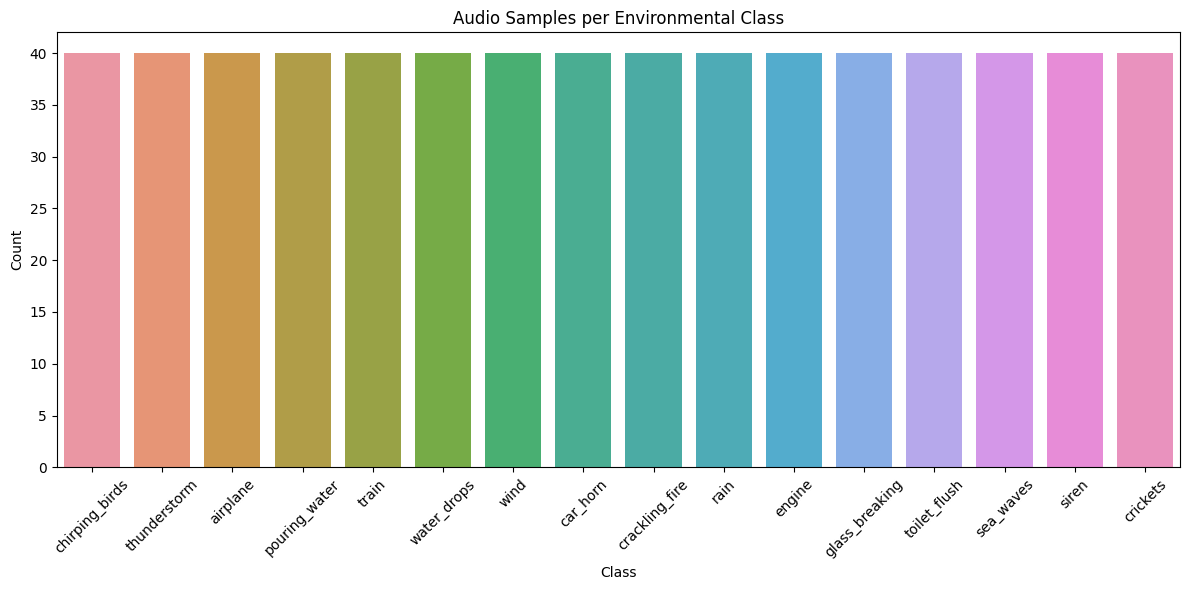

In [9]:
# 1. Class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=env_df, x='category', order=env_df['category'].value_counts().index)
plt.title('Audio Samples per Environmental Class')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Interpretation of Bar Chart**

The bar chart shows that each selected environmental sound class contains exactly 40 audio samples, confirming a balanced dataset. This ensures fair representation during training and helps improve model performance across all categories.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


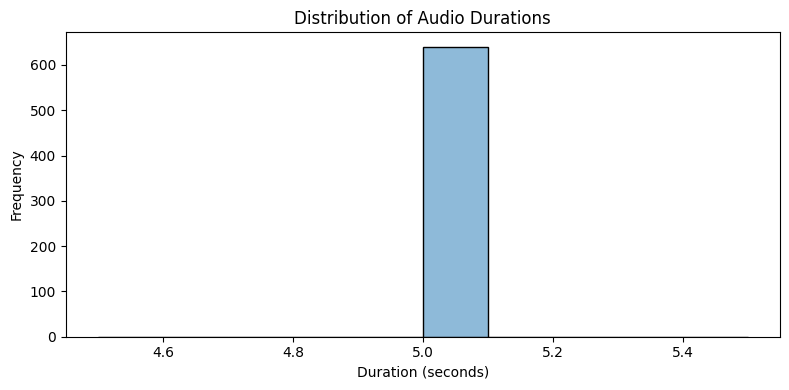

In [6]:
# 2. Audio duration distribution
durations = []
for fname in env_df['filename']:
    y, sr = librosa.load(os.path.join(AUDIO_DIR, fname), sr=None)
    durations.append(len(y) / sr)

plt.figure(figsize=(8, 4))
sns.histplot(durations, bins=10, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Interpretation of the Histogram**


The histogram shows that all environmental audio samples in my filtered dataset showing a uniform duration of 5 seconds. This consistent length ensures that each audio file is of equal size and format, which simplifies preprocessing and guarantees uniformity in feature extraction and model input.


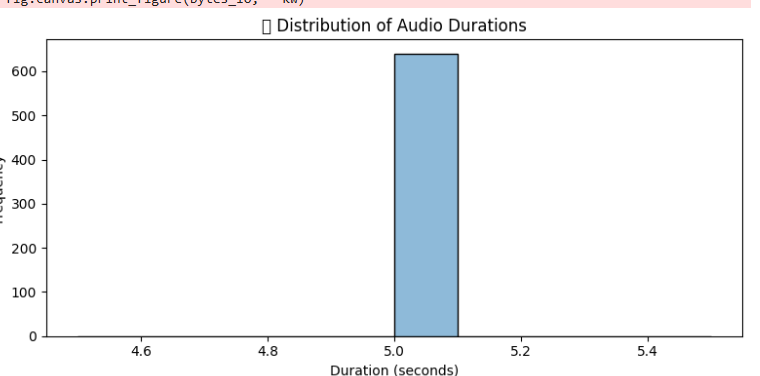

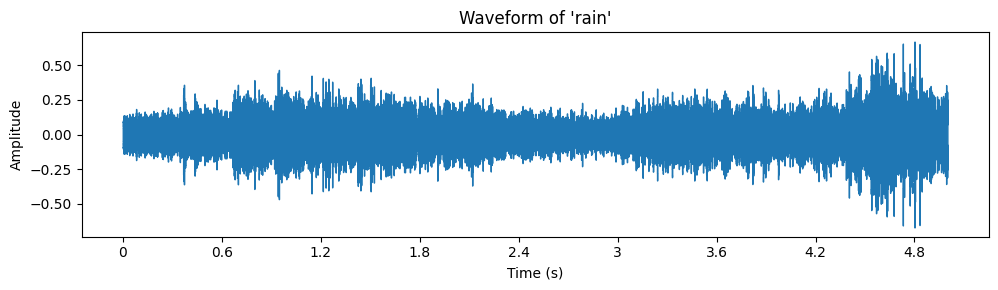

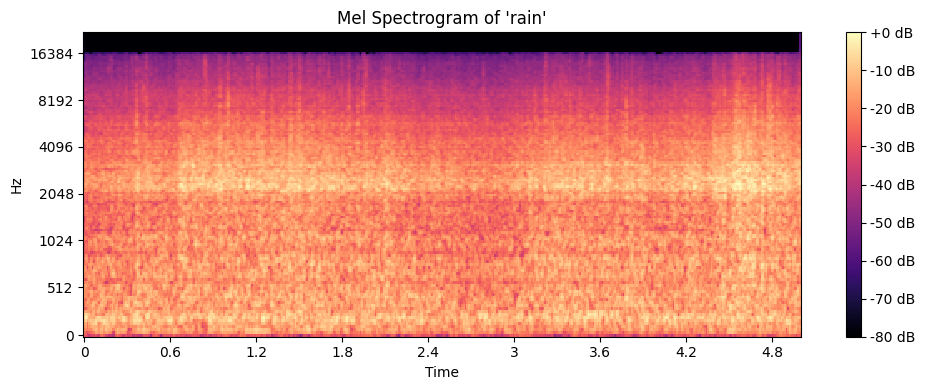

In [7]:
# 3. Plot a waveform from a random sample
sample = env_df.sample(1).iloc[0]
file_path = os.path.join(AUDIO_DIR, sample['filename'])
y, sr = librosa.load(file_path, sr=None)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of '{sample['category']}'")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 4. Plot Mel Spectrogram of same sample
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S,  ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram of '{sample['category']}'")
plt.tight_layout()
plt.show()

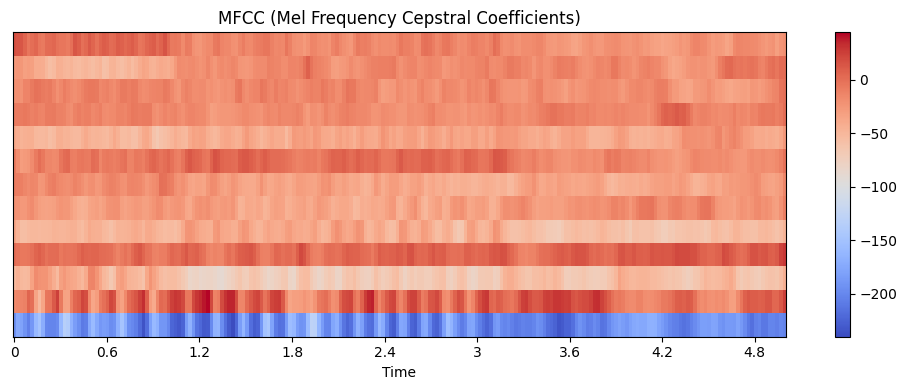

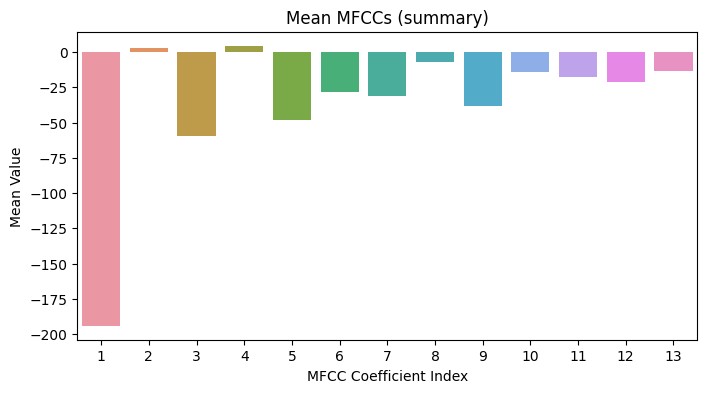

In [8]:
# Load a sample file
sample_file = AUDIO_DIR + env_df.iloc[0]['filename']
y, sr = librosa.load(sample_file)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfccs_mean = np.mean(mfccs, axis=1)

# Plot MFCCs heatmap
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (Mel Frequency Cepstral Coefficients)')
plt.tight_layout()
plt.show()

# Plot mean MFCCs (summary across time)
plt.figure(figsize=(8, 4))
sns.barplot(x=np.arange(1, 14), y=mfccs_mean)
plt.title('Mean MFCCs (summary)')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean Value')
plt.show()

Interpretation of MFCC Plots


The MFCC heatmap shows stable frequency patterns over time, indicating consistent environmental sounds. The bar chart reveals that the first MFCC captures most of the energy, while others describe finer details like pitch and timbre. Together, these features effectively represent the audio's spectral characteristics, making them suitable for training a sound classification model.

# **Data Preprocessing**


In [19]:
from sklearn.preprocessing import StandardScaler

#Patch deprecated np.complex for compatibility
np.complex = complex

# Enhanced feature extraction function
def extract_features(file_path, n_mfcc=13, n_chroma=12, n_mel=128):
    """Extract comprehensive audio features"""
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=22050)
        y, _ = librosa.effects.trim(y)
        
        # Normalize
        if len(y) > 0:
            y = y / (np.max(np.abs(y)) + 1e-6)
        else:
            return None
            
        # Extract multiple features
        features = []
        
        # 1. MFCCs (13 coefficients, keep temporal info)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features.extend([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1),
            np.max(mfcc, axis=1),
            np.min(mfcc, axis=1)
        ])
        
        # 2. Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        features.extend([
            np.mean(chroma, axis=1),
            np.std(chroma, axis=1)
        ])
        
        # 3. Mel-scale spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mel)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        features.extend([
            np.mean(mel_db, axis=1),
            np.std(mel_db, axis=1)
        ])
        
        # 4. Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        
        features.extend([
            np.mean(spectral_centroids),
            np.std(spectral_centroids),
            np.mean(spectral_rolloff),
            np.std(spectral_rolloff),
            np.mean(spectral_bandwidth),
            np.std(spectral_bandwidth),
            np.mean(zero_crossing_rate),
            np.std(zero_crossing_rate)
        ])
        
        # Flatten all features
        return np.concatenate([np.array(f).flatten() for f in features])
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features for all files
print("Extracting enhanced features...")
features = []
labels = []

for idx, row in env_df.iterrows():
    file_path = os.path.join(AUDIO_DIR, row['filename'])
    feature_vector = extract_features(file_path)
    
    if feature_vector is not None:
        features.append(feature_vector)
        labels.append(row['category'])

# Convert to arrays
X = np.array(features)
y = np.array(labels)

print(f"Feature extraction complete. Shape: {X.shape}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Ensure balanced split
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")


Extracting enhanced features...


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction complete. Shape: (640, 340)
Training set: (512, 340)
Test set: (128, 340)
Number of classes: 16
Classes: ['airplane' 'car_horn' 'chirping_birds' 'crackling_fire' 'crickets'
 'engine' 'glass_breaking' 'pouring_water' 'rain' 'sea_waves' 'siren'
 'thunderstorm' 'toilet_flush' 'train' 'water_drops' 'wind']


# **Model Creation **

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Function for model building and training
def train_and_evaluate(X_train, y_train_cat, X_val, y_val_cat, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    print("\nModel Architecture:")
    model.summary()

    print("\nStarting training...")
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=30,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_val, y_val_cat, verbose=0)
    print(f"\nFinal Validation Accuracy: {test_accuracy:.4f}")

    return model, history

model, history = train_and_evaluate(X_train, y_train_cat, X_test, y_test_cat, num_classes)



Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       174,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,696 (1.34 MB)

 Trainable params: 349,904 (1.33 MB)

 Non-trainable params: 1,792 (7.00 KB)


Starting training...
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1175 - loss: 3.1564 - val_accuracy: 0.3516 - val_loss: 2.2492 - learning_rate: 0.0010
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3548 - loss: 2.0403 - val_accuracy: 0.5000 - val_loss: 1.7431 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4945 - loss: 1.6071 - val_accuracy: 0.5781 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5589 - loss: 1.4213 - val_accuracy: 0.6172 - val_loss: 1.2410 - learning_rate: 0.0010
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6074 - loss: 1.2400 - val_accuracy: 0.6719 - val_loss: 1.0431 - learning_rate: 0.0010
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6690 - loss: 1.0949 - val_accuracy: 0.7188 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6742 - los

In [9]:
def evaluate_model(model, X_test, y_test_cat, le, print_samples=5):
    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred_labels = y_pred_probs.argmax(axis=1)
    y_true_labels = y_test_cat.argmax(axis=1)

    # Convert to string labels
    y_pred_str_labels = le.inverse_transform(y_pred_labels)
    y_true_str_labels = le.inverse_transform(y_true_labels)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

    # Individual Metrics
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # : Show a few prediction samples
    print(f"\nSample predictions (first {print_samples}):")
    for i in range(min(print_samples, len(y_true_labels))):
        print(f"True: {y_true_str_labels[i]} | Predicted: {y_pred_str_labels[i]}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }, y_true_labels, y_pred_labels
    
metrics, y_true_labels, y_pred_labels = evaluate_model(model, X_test, y_test_cat, le)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
                precision    recall  f1-score   support

      airplane       1.00      0.75      0.86         8
      car_horn       0.86      0.75      0.80         8
chirping_birds       0.89      1.00      0.94         8
crackling_fire       0.89      1.00      0.94         8
      crickets       1.00      0.62      0.77         8
        engine       0.86      0.75      0.80         8
glass_breaking       0.89      1.00      0.94         8
 pouring_water       0.86      0.75      0.80         8
          rain       0.86      0.75      0.80         8
     sea_waves       0.86      0.75      0.80         8
         siren       1.00      0.88      0.93         8
  thunderstorm       1.00      1.00      1.00         8
  toilet_flush       1.00      1.00      1.00         8
         train       0.47      0.88      0.61         8
   water_drops       0.78      0.88      0.82         8
          wind       0.50      0.50      

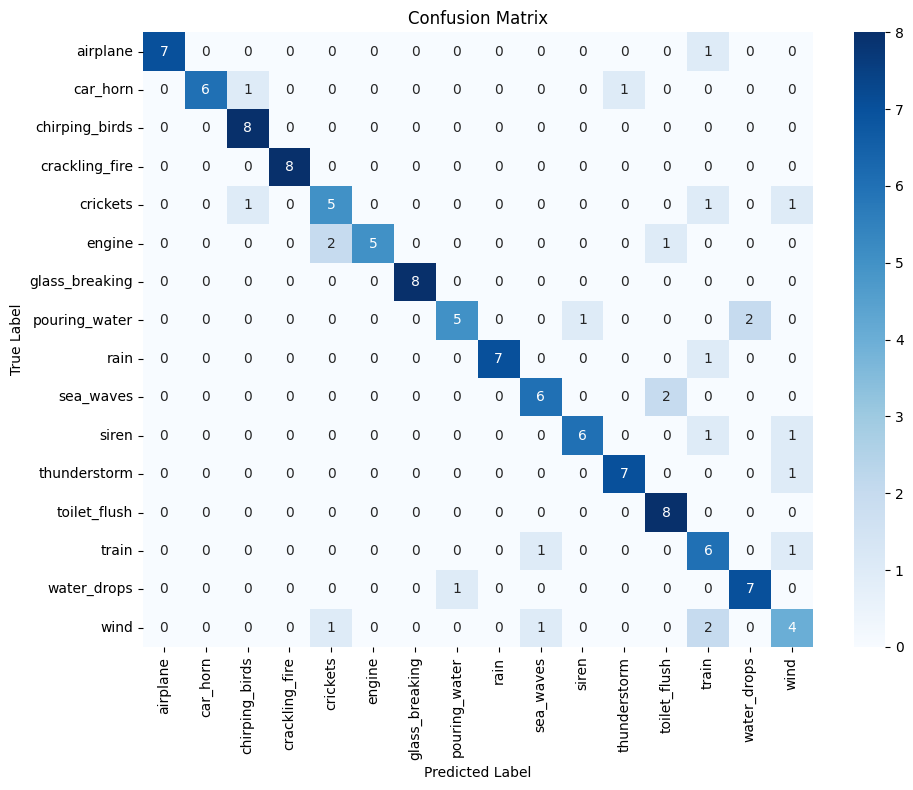

In [12]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [17]:

# Making Single sample prediction
single_sample = X_test[0].reshape(1, -1)
predicted_label = predict_single_sample(model, single_sample, le)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label: siren


In [21]:
import joblib
import pickle

# Save the trained model
model.save("audio_classifier_model.h5")

# Save the LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# save the Scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']